# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

## t-test for effects of all mutations combined
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

### List of interacting proteins (according to STRING and Uniprot)

In [4]:
#Build the protein list; this may have only a single protein if desired
protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']

In [5]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

In [6]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

In [7]:
print(significant_proteins)
print(significant_pvals)

[]
[]


### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [8]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = protList

In [9]:
sites = phos.columns
p_values = []
site_names = []

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['IRS1-S1005' 'IRS1-S1100' 'IRS1-S1101' 'IRS1-S1133' 'IRS1-S1134'
 'IRS1-S270' 'IRS1-S323' 'IRS1-S330' 'IRS1-S374' 'IRS1-S415' 'IRS1-S527'
 'IRS1-S531' 'IRS1-S629' 'IRS1-S636' 'IRS1-S672' 'IRS1-S766' 'IRS1-T305'
 'IRS1-T309' 'IRS2-S1100' 'IRS2-S391' 'IRS2-S560' 'IRS2-S577' 'IRS2-S731'
 'IRS2-S736' 'IRS2-S973' 'IRS2-T520' 'PTEN-T555' 'LAMTOR1-S27'
 'MTOR-S2481' 'RPS6KA1-T56' 'RPS6KA3-S375' 'RPS6KA4-S682' 'RPS6KA4-S737'
 'RPS6KA4-T22' 'RPS6KA5-S448' 'RPS6KC1-S872' 'MAPK1-T181' 'MAPK12-Y185'
 'MAPK14-Y182' 'MAPK3-Y204' 'MAPK7-T733' 'MAPKAP1-S270' 'MAPKAPK2-T222'
 'MAPKAPK5-S212' 'MAPKBP1-S1263' 'MAPKBP1-T796' 'CDK5RAP2-S1074'
 'CDK5RAP2-T1677']
[0.02258477 0.00118736 0.0020507  0.03511316 0.00341013 0.00401731
 0.0249088  0.02258477 0.00401731 0.00817029 0.02799875 0.00504059
 0.00323493 0.00746695 0.02252734 0.00770251 0.00770251 0.02258477
 0.00152472 0.00268533 0.00401731 0.00914516 0.01700895 0.00469637
 0.03511316 0.03511316 0.02258477 0.00341013 0.04702081 0.0364313
 0.02258477 0.00

### Plot phosphorylation levels and gene mutation
<b>Note:</b> There may be fewer data points due to NA values

SIGNIFICANT SITES LENGTH:  48
      IRS1-S1005           Mutation Patient_Type
S001    -0.50100  Missense_Mutation        Tumor
S002     0.17600           Wildtype        Tumor
S003     0.08390  Missense_Mutation        Tumor
S004     0.04480           Wildtype        Tumor
S005    -0.22300           Wildtype        Tumor
S006    -0.64900           Wildtype        Tumor
S007    -0.21200           Wildtype        Tumor
S008     0.21400           Wildtype        Tumor
S009     0.55400  Missense_Mutation        Tumor
S010    -0.08240  Missense_Mutation        Tumor
S011    -0.64400           Wildtype        Tumor
S012    -1.29000  Missense_Mutation        Tumor
S013    -0.12500           Wildtype        Tumor
S014    -0.39700  Missense_Mutation        Tumor
S015     0.37900           Wildtype        Tumor
S016    -0.77400           Wildtype        Tumor
S017    -0.90900           Wildtype        Tumor
S018    -0.29100  Missense_Mutation        Tumor
S019     0.01670           Wildtype    

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

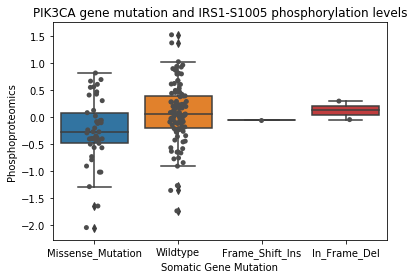

In [18]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above
gene = 'PIK3CA'
site = significant_sites[0]
print("SIGNIFICANT SITES LENGTH: ", len(significant_sites))

#print(somatic_mutations)

#Build the dataframe for plotting
#genedf = somatic_mutations[gene].to_frame()
genedf = CPTAC.compare_mutations(phos, site, gene)

print(genedf)
#sites = phos.filter(regex=site)
#genedf = genedf.add(sites, fill_value=0)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Test for phosphorylation levels and protein abundance

In [19]:
#Specify the pattern for all phosphorylation sites as well as the protein of interest
phosProt = phos.filter(regex='PIK3CA') 
protein = 'PIK3CA'
sigPhosProtResults = []

#Build dataframe with protein levels and phosphorylation levels
proteindf = proteomics[protein].to_frame()
phosProtCross = proteindf.add(phosProt, fill_value=0)

#Bonferroni correction
pcutoff = 0.05/len(cross.columns)

#Test each site for significance and print the results
for loc in phosProtCross.columns:
    if not loc == protein:
        oneSitedf = phosProtCross[[loc, protein]].dropna(axis=0)
        pearsonresult = pearsonr(oneSitedf[loc], oneSitedf[protein])
        if(pearsonresult[1] < pcutoff):
            sigPhosProtResults.append(loc)
            print("Results for " + loc)
            print(pearsonresult)

Results for PIK3CA-S312
(0.5597690804706072, 9.70607537359938e-09)
Results for PIK3CA-T313
(0.5795790014886743, 2.1587859293485523e-09)


### Scatterplot of phosphorylation levels vs. protein abundance (mutation included)

In [17]:
#Specify a protein, a gene and a site; you may use a string to specify the site or reference sigPhosProtResults above
protein = 'CTNNB1'
gene = 'CTNNB1'
site = sigPhosProtResults[1]

#Build the dataframe for plotting
protdf = proteomics[protein].to_frame()
protdfName = protein + " protein levels" #Technically only necessary when the gene and the protein have the same name
protdf.columns = [protdfName]
sites = phos.filter(regex=site)
protdf = protdf.add(sites, fill_value=0)

genedf = somatic_mutations[gene].to_frame()
genedfName = gene + " mutation"
genedf.columns = [genedfName]
finaldf = protdf.add(genedf, fill_value=0)

alt.Chart(finaldf).mark_point().encode(
    alt.X(protdfName),
    alt.Y(site),
    alt.Color(genedfName, type='nominal')
).interactive()

KeyError: 'CTNNB1'